In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco")

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
jax.default_device(jax.devices("gpu")[0])
import jaxopt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.simdata_i3 import I3SimHandlerFtr
from lib.plotting import plot_event, adjust_plot_1d
from lib.geo import center_track_pos_and_time_based_on_data

from lib.network import get_network_eval_v_fn

from dom_track_eval import get_eval_network_doms_and_track

from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=False, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()

import time

In [2]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

muon energy: 4.7 TeV
n_doms 102


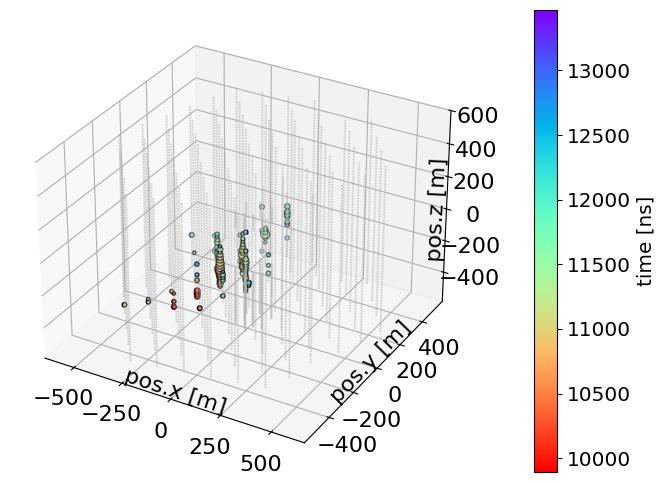

In [12]:
# Event Index.
event_index = 2

# Get network and eval logic.
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network')
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v)

# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

# Produce and save an event view.
plot_event(event_data, geo=sim_handler.geo)

In [13]:
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("old track vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)
print("new track vertex:", centered_track_pos)

# Create some n_photons from qtot (by rounding up).
n_photons = np.round(event_data['charge'].to_numpy()+0.5)

# Combine into single data tensor for fitting.
fitting_event_data = jnp.column_stack([
                                        jnp.array(event_data[['x', 'y', 'z', 'time']].to_numpy()),
                                        jnp.array(n_photons)
                                   ])

old track vertex: [ -777.15166078 -1656.22843231 -1472.45624098]
new track vertex: [-164.52122541  320.02418746 -330.17880541]


In [14]:
from lib.cgamma import c_multi_gamma_prob_v

def get_neg_c_triple_gamma_llh_const_vertex(eval_network_doms_and_track_fn, 
                                            eps=jnp.float64(1.e-20)):

    @jax.jit
    def neg_c_triple_gamma_llh_const_vertex(track_direction, 
                                            track_vertex, 
                                            track_time, 
                                            event_data):
        dom_pos = event_data[:, :3]
        first_hit_times = event_data[:, 3]
        logits, av, bv, geo_time = eval_network_doms_and_track_fn(dom_pos, track_vertex, track_direction)

        mix_probs = jax.nn.softmax(logits)
        delay_time = first_hit_times - (geo_time + track_time)

        sigma = 3.0 # width of convolution 
        # evaluate llh and grads only in the safe region t > -X_safe * sigma
        X_safe = 20
        safe_delay_time = jnp.where(delay_time > -X_safe * sigma, delay_time, -X_safe * sigma)
    
        sigma = 3.0
        delta = 0.1
        return -2.0 * jnp.sum(jnp.log(c_multi_gamma_prob_v(safe_delay_time, 
                                                           mix_probs,
                                                           av,
                                                           bv,
                                                           sigma,
                                                           delta)))

    return neg_c_triple_gamma_llh_const_vertex

In [15]:
neg_llh = get_neg_c_triple_gamma_llh_const_vertex(eval_network_doms_and_track)

@jax.jit
def neg_llh_5D(x):
    track_direction = x[:2]
    track_vertex = x[2:]
    return neg_llh(track_direction, track_vertex, centered_track_time, fitting_event_data)

In [16]:
with HiddenPrints():
    solver_3 = jaxopt.LBFGSB(fun=neg_llh_5D, 
                        maxiter=500, 
                        jit=True,
                        tol=0.01)

    solve = jax.jit(solver_3.run)
    solver_3_sol = solve(jnp.concatenate([track_src, centered_track_pos]), 
                         (jnp.array([0.0, 0.0, -500.0, -500.0, -500.0]),
                         jnp.array([np.pi, 2.0*np.pi, 500.0, 500.0, 500.0])))
    
print(solver_3_sol.params)
print(solver_3_sol.state[1])

[   2.07337458    4.40929344 -165.17385163  320.04357459 -330.15053851]
1333.3841810964818


In [17]:
@jax.jit
def neg_llh_3D(track_vertex, track_direction):
    return neg_llh(track_direction, track_vertex, centered_track_time, fitting_event_data)

solver = jaxopt.LBFGSB(fun=neg_llh_3D, 
                        maxiter=500, 
                        jit=True,
                        tol=0.01)

solve = jax.jit(solver.run)
bounds = (jnp.array([-500.0, -500.0, -500.0]), jnp.array([500.0, 500.0, 500.0]))

@jax.jit
def another_profile(track_direction):

    sol = solve(centered_track_pos, bounds, track_direction)
    return sol.state[1]

#another_profile_v = jax.vmap(another_profile, 0, 0)

In [18]:
n_eval = 20
zenith = jnp.linspace(track_src[0]-0.03, track_src[0]+0.03, n_eval)
azimuth = jnp.linspace(track_src[1]-0.03, track_src[1]+0.03, n_eval)
X, Y = jnp.meshgrid(zenith, azimuth)
init_dirs = jnp.column_stack([X.flatten(), Y.flatten()])
logls = np.zeros(len(init_dirs))

start = time.time()
with HiddenPrints():
    for i, tdir in enumerate(init_dirs):
        if i%50==0:
            print(i)
    
        logls[i] = another_profile(tdir)

end = time.time()
print(end - start, "seconds")

102.54457521438599 seconds


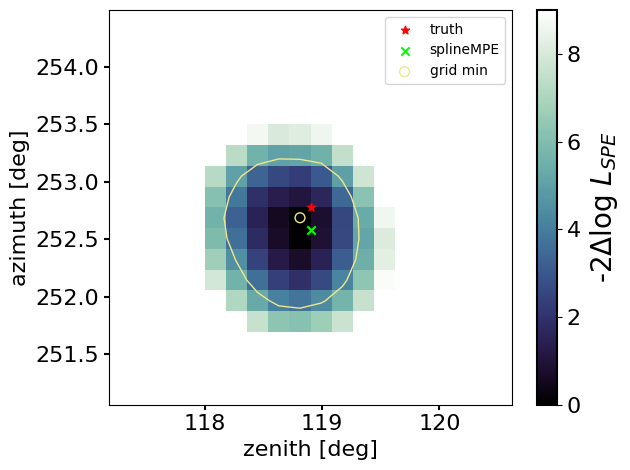

In [19]:
logls = logls.reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([9, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{SPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-0.03, track_src[0]+0.03]))
ax.set_ylim(np.rad2deg([track_src[1]-0.03, track_src[1]+0.03]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

#zenith = result_bfgs.x[0]
#azimuth = result_bfgs.x[1]
#ax.scatter(np.rad2deg(zenith), np.rad2deg(azimuth), marker='^', color='cyan', label='BFGS')

# generate contours
contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

plt.legend()
plt.tight_layout()
plt.show()

In [20]:
'''
start = time.time()
with HiddenPrints():
    logls = another_profile_v(init_dirs)

end = time.time()
print(end - start, "seconds")
'''

'\nstart = time.time()\nwith HiddenPrints():\n    logls = another_profile_v(init_dirs)\n\nend = time.time()\nprint(end - start, "seconds")\n'